# Importación modulos y datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib 

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import datasets
from sklearn.preprocessing import normalize


matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
data = pd.read_csv("conchillas_merge.csv", low_memory = False, keep_default_na = False, na_values = '')

In [3]:
# No hay individuos juveniles en el dataset (ancho total menor a 8 milímetros o ausencia de labio)

len(np.logical_or(data.Labio == 1, data.AT >= 8)) == len(data)

True

# Exploración y limpieza de datos

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Lote       423 non-null    int64  
 1   Individuo  423 non-null    int64  
 2   AE         423 non-null    float64
 3   LE         423 non-null    float64
 4   AT         423 non-null    float64
 5   LT         423 non-null    float64
 6   AA         423 non-null    float64
 7   LA         423 non-null    float64
 8   NV         423 non-null    float64
 9   Morfotipo  423 non-null    object 
 10  Labio      422 non-null    float64
 11  cox1-lsu   106 non-null    object 
dtypes: float64(8), int64(2), object(2)
memory usage: 39.8+ KB


In [5]:
# Creación de diccionario y reemplazo de haplotipos combinados (105) por haplogrupos (3)
ht = ['AA', 'AB', 'BA', 'CA', 'DA', 'EA', 'FA', 'LA', 'NA', 'OA', 'JH', 'KI', 'GC', 'GD', 'GE', 'GF', 'HG', 'IG', 'MG']
hg = ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '2', '2', '2']
hg_ht_rep = dict(zip(ht, hg))

data["haplogrupos"] = data["cox1-lsu"].replace(hg_ht_rep)

In [6]:
data["Labio"][6] = 0

C:\Users\maela\AppData\Local\Temp/ipykernel_11472/1489253307.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Labio"][6] = 0


In [7]:
data.iloc[:,2:].describe()

,AE,LE,AT,LT,AA,LA,NV,Labio
count,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000
mean,6.241608,1.763570,13.270284,9.780260,7.695130,6.265035,5.145248,0.576832
std,0.980104,0.375682,1.941412,1.435288,1.233105,0.913267,0.297400,0.494647
min,3.200000,0.710000,8.050000,6.170000,4.790000,4.270000,4.020000,0.000000
25%,5.585000,1.500000,11.790000,8.780000,6.770000,5.605000,4.950000,0.000000
50%,6.250000,1.760000,13.220000,9.690000,7.610000,6.150000,5.180000,1.000000
75%,6.905000,2.030000,14.585000,10.830000,8.550000,6.790000,5.340000,1.000000
max,9.040000,3.130000,19.090000,14.450000,11.950000,9.720000,5.950000,1.000000


In [8]:
values = {"LU": 0, "LB":1, "DU":2}
data["Morfotipo"] = data["Morfotipo"].map(values)

In [9]:
data.Morfotipo.unique()

array([0, 1, 2], dtype=int64)

In [10]:
round(data['Morfotipo'].value_counts(normalize = True)*100, 2)
data['haplogrupos'].value_counts()
data['cox1-lsu'].value_counts()

0    86.05
1    13.24
2     0.71
Name: Morfotipo, dtype: float64

0    85
2    12
1     9
Name: haplogrupos, dtype: int64

AA    68
HG    10
GC     3
LA     3
GF     3
BA     3
GE     2
CA     2
OA     2
AB     1
MG     1
IG     1
GD     1
KI     1
DA     1
NA     1
FA     1
JH     1
EA     1
Name: cox1-lsu, dtype: int64

In [11]:
data = pd.get_dummies(data, columns = ["Morfotipo"], drop_first = True)

### Creación columnas nuevas

In [12]:
data["Ratio_LE_AE"] = data["LE"]/data["AE"]
data["Ratio_LT_AT"] = data["LT"]/data["AT"]
data["Ratio_LA_AA"] = data["LA"]/data["AA"]

data["Ratio_LE_LT"] = data["LE"]/data["LT"]
data["Ratio_AE_AT"] = data["AE"]/data["AT"]
data["Ratio_LA_LT"] = data["LA"]/data["LT"]
data["Ratio_AA_AT"] = data["AA"]/data["AT"]
data["Ratio_LE_LA"] = data["LE"]/data["LA"]
data["Ratio_AE_AA"] = data["AE"]/data["AA"]

In [14]:
data.head()

,Lote,Individuo,AE,LE,AT,LT,AA,LA,NV,Labio,...,Morfotipo_2,Ratio_LE_AE,Ratio_LT_AT,Ratio_LA_AA,Ratio_LE_LT,Ratio_AE_AT,Ratio_LA_LT,Ratio_AA_AT,Ratio_LE_LA,Ratio_AE_AA
0,96,1,6.11,2.22,13.95,10.39,8.19,6.99,5.30,1.0,...,0,0.363339,0.744803,0.853480,0.213667,0.437993,0.672762,0.587097,0.317597,0.746032
1,96,2,5.69,1.45,11.68,8.34,6.45,5.89,5.00,1.0,...,0,0.254833,0.714041,0.913178,0.173861,0.487158,0.706235,0.552226,0.246180,0.882171
2,96,5,6.14,1.80,13.72,10.00,8.13,6.08,5.12,1.0,...,0,0.293160,0.728863,0.747847,0.180000,0.447522,0.608000,0.592566,0.296053,0.755228
3,96,6,6.54,2.18,11.66,9.21,6.66,4.93,5.47,0.0,...,0,0.333333,0.789880,0.740240,0.236699,0.560892,0.535288,0.571184,0.442191,0.981982
4,99,1,6.01,1.58,12.59,9.09,6.92,6.61,5.15,1.0,...,0,0.262895,0.722002,0.955202,0.173817,0.477363,0.727173,0.549643,0.239032,0.868497


In [15]:
data.columns

Index(['Lote', 'Individuo', 'AE', 'LE', 'AT', 'LT', 'AA', 'LA', 'NV', 'Labio',
       'cox1-lsu', 'haplogrupos', 'Morfotipo_1', 'Morfotipo_2', 'Ratio_LE_AE',
       'Ratio_LT_AT', 'Ratio_LA_AA', 'Ratio_LE_LT', 'Ratio_AE_AT',
       'Ratio_LA_LT', 'Ratio_AA_AT', 'Ratio_LE_LA', 'Ratio_AE_AA'],
      dtype='object')

### Relación entre variables

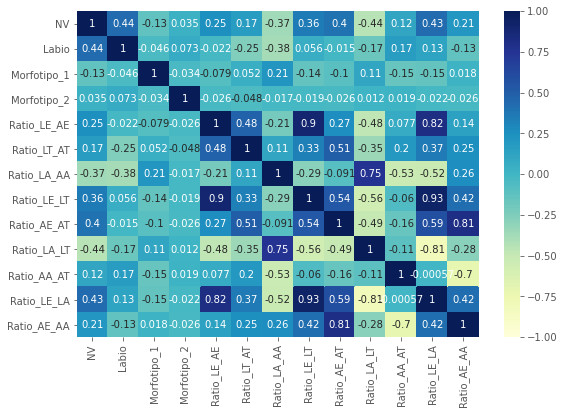

In [16]:
def _print_matriz_correlacion(dflocal):
    plt.rcParams['figure.figsize'] = (9, 6)
    plt.rcParams['font.size'] = 10
    sns.heatmap(dflocal, vmin = -1, vmax = 1, center = 0, cmap = "YlGnBu", annot = True)
_print_matriz_correlacion(data.iloc[8:,8:].corr())  

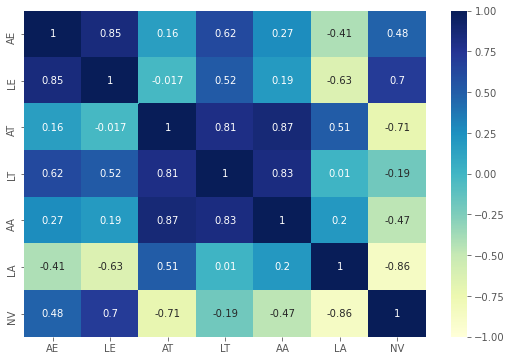

In [17]:
#variables originales del dataset
_print_matriz_correlacion(data.iloc[2:9,2:9].corr())  

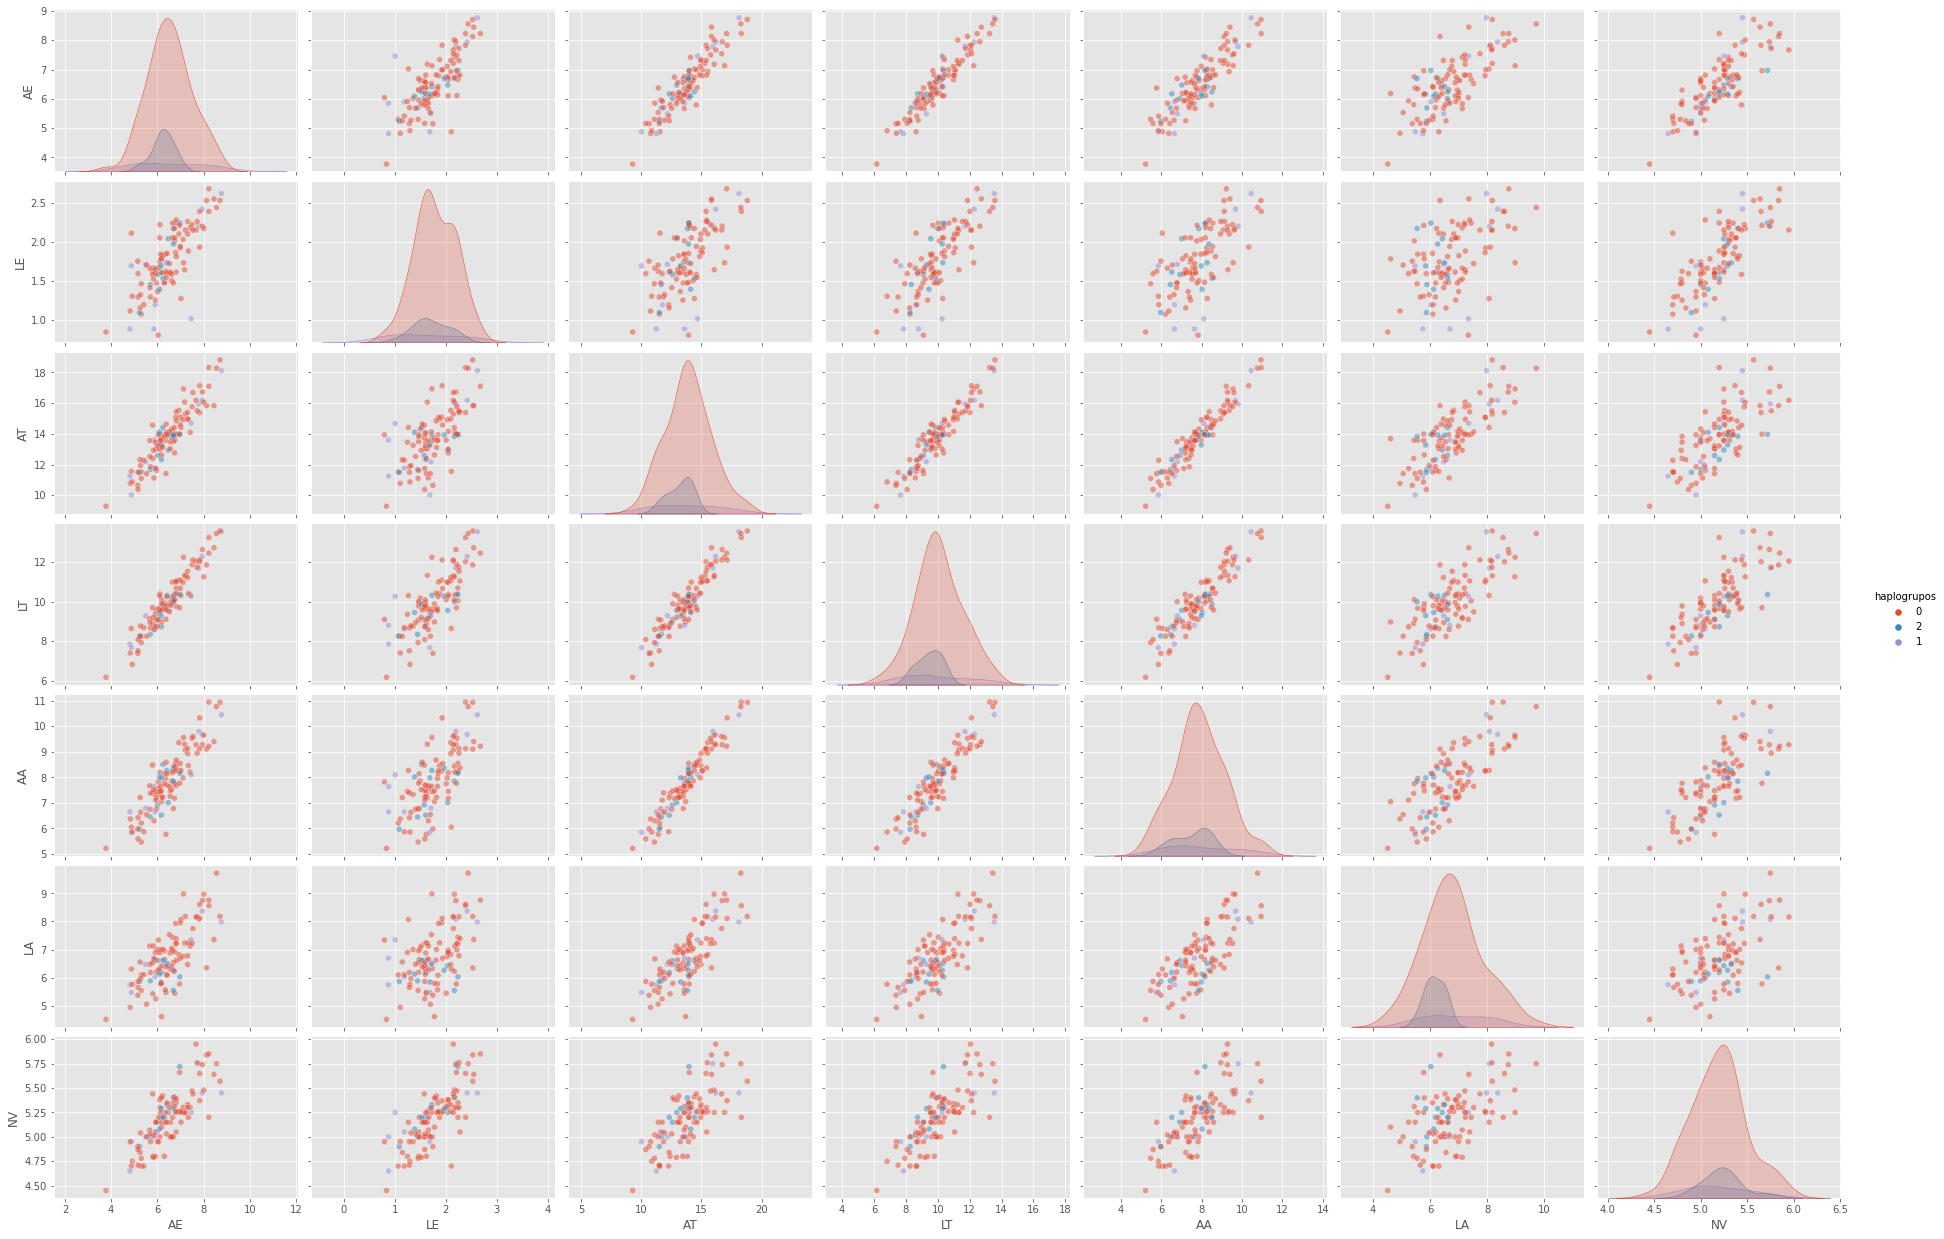

In [21]:
sns.pairplot(data=data,x_vars=['AE','LE','AT','LT','AA','LA','NV'],\
         y_vars=['AE','LE','AT','LT','AA','LA','NV'],hue='haplogrupos',plot_kws={'alpha': 0.5},aspect=1.5);

### Distribución de las observaciones

In [ ]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15, 9))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  
    plt.show()

In [ ]:
draw_histograms(data, data[['AE','LE','AT','LT','AA','LA','NV','Ratio_LE_AE','Ratio_LT_AT','Ratio_LA_AA','Ratio_LE_LT','Ratio_AE_AT','Ratio_LA_LT','Ratio_AA_AT','Ratio_LE_LA','Ratio_AE_AA']], 4, 4)

# Modelos de clustering

## Importación modulos y dataset

In [22]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import silhouette_samples, silhouette_score,calinski_harabasz_score
from scipy.cluster import hierarchy 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.cm as cm

## Prueba Kmeans

### Con las variables originales

In [23]:
x = data[['AE','LE','AT','LT','AA','LA','NV','Morfotipo_1','Morfotipo_2','Labio']]
y_true = data["haplogrupos"]

scaler = StandardScaler()
x_scaled=scaler.fit_transform(x);

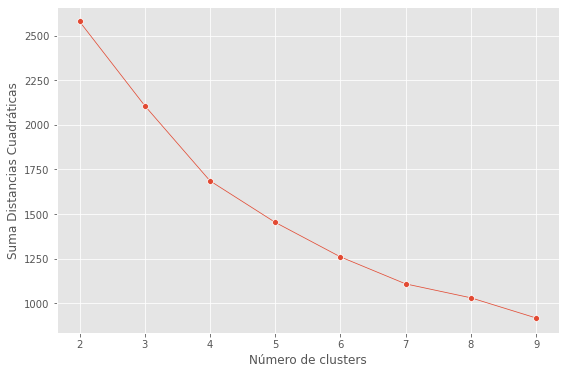

In [24]:
sq_distances=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters'); 

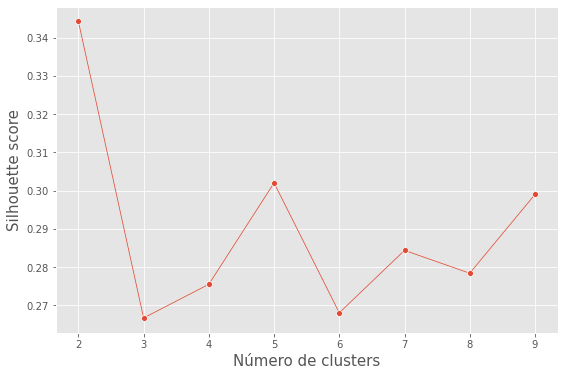

In [25]:
sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x_scaled)
    score=silhouette_score(x_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

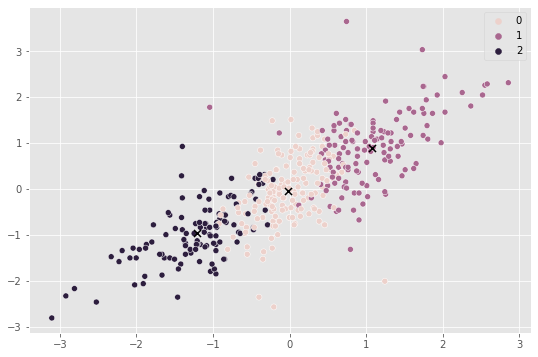

In [26]:
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x_scaled[:,0],y=x_scaled[:,1],hue=labels,legend='full');

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k');

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'Kmeans')

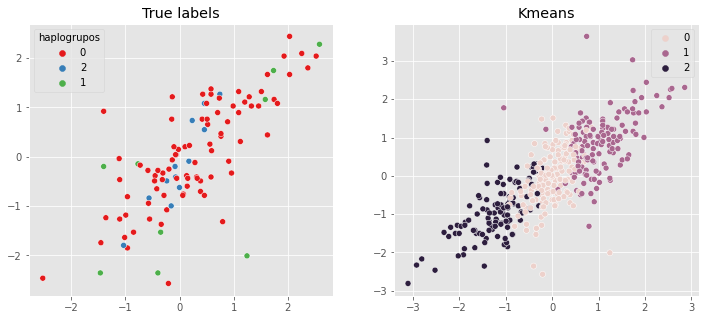

In [27]:
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_scaled[:,0], y = x_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x_scaled[:,0], y = x_scaled[:,1],hue=labels,ax=ax[1])
ax[1].set_title('Kmeans')

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'Kmeans')

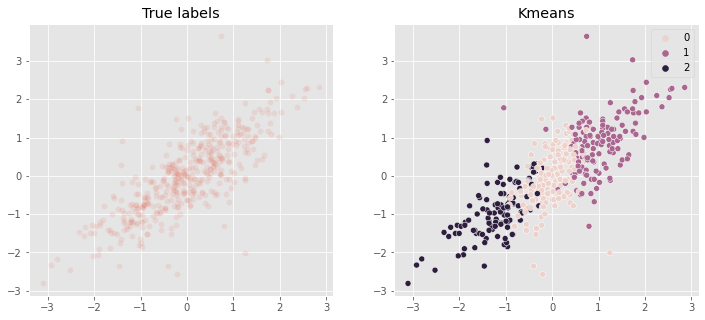

In [28]:
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_scaled[:,0], y = x_scaled[:,1],ax=ax[0], alpha=0.1)
#sns.scatterplot(x = x_scaled[indices,0], y = x_scaled[indices,1],hue=y_true[y_true!="0"],ax=ax[0], palette="magma")
ax[0].set_title('True labels')
sns.scatterplot(x = x_scaled[:,0], y = x_scaled[:,1],hue=labels,ax=ax[1])
ax[1].set_title('Kmeans')

In [29]:
indices = y_true[y_true!="0"].index

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

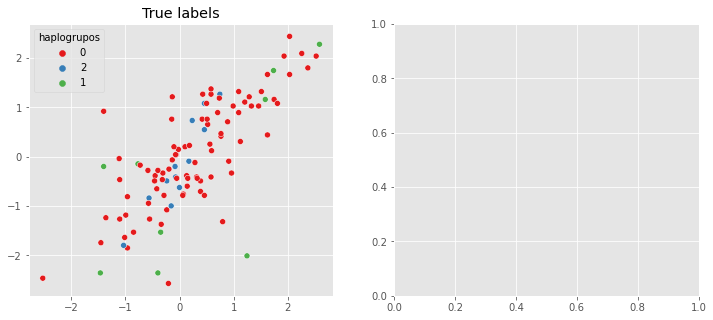

In [30]:
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_scaled[:,0], y = x_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')

In [31]:
x_scaled.shape
x_scaled[indices].shape

(423, 10)

(338, 10)

In [ ]:
x_scaled[indices,0]

In [ ]:
x_scaled[indices,1]

In [32]:
y_true[y_true!="0"]

1        2
2      NaN
3      NaN
4        2
5        2
      ... 
401    NaN
418    NaN
420    NaN
421    NaN
422    NaN
Name: haplogrupos, Length: 338, dtype: object

In [34]:
#sns.heatmap(confusion_matrix(y_true,labels),annot=True,cmap='Blues',fmt=".0f");

#print(classification_report(y_true,labels))

### Con todas las variables

In [35]:
x_R = data[['AE','LE','AT','LT','AA','LA','NV','Morfotipo_1','Morfotipo_2','Labio','Ratio_LE_AE','Ratio_LT_AT','Ratio_LA_AA','Ratio_LE_LT','Ratio_AE_AT','Ratio_LA_LT','Ratio_AA_AT','Ratio_LE_LA','Ratio_AE_AA']]
#x_R = data[['NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT']]
y_true = data["haplogrupos"]

scaler = StandardScaler()
x_R_scaled=scaler.fit_transform(x_R);

In [36]:
x_R_scaled.shape

(423, 19)

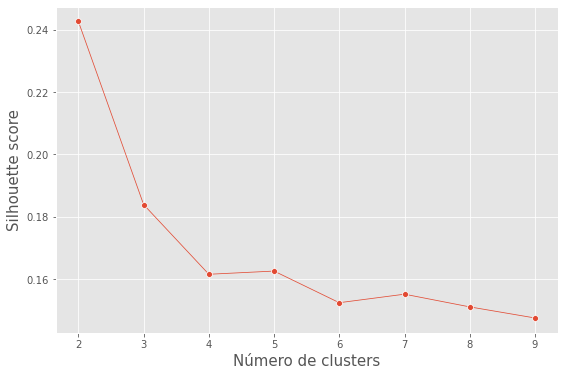

In [37]:
sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x_R_scaled)
    score=silhouette_score(x_R_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

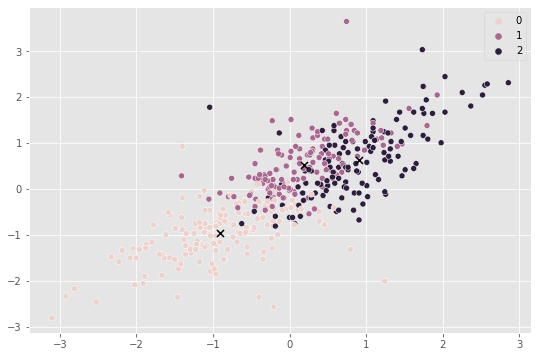

In [38]:
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x_R_scaled)

labels_R = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids_R = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x_R_scaled[:,0],y=x_R_scaled[:,1],hue=labels_R,legend='full');

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids_R[:,0],centroids_R[:,1],marker='x',s=50,color='k');

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'Kmeans_R')

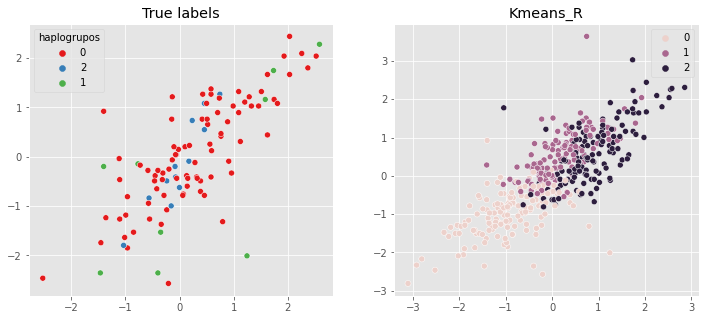

In [39]:
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_R_scaled[:,0], y = x_R_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x_R_scaled[:,0], y = x_R_scaled[:,1],hue=labels_R,ax=ax[1])
ax[1].set_title('Kmeans_R')

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

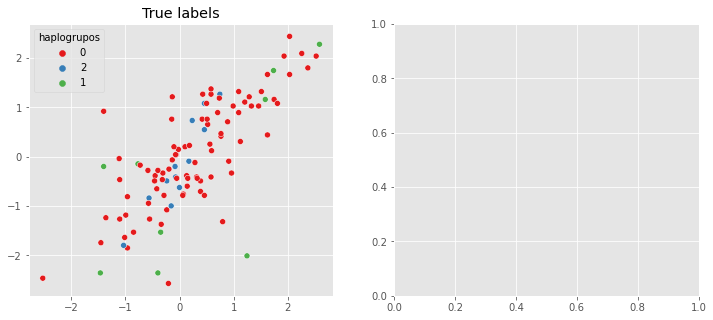

In [40]:
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_R_scaled[:,0], y = x_R_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')

## DBSCAN

In [41]:
from scipy.spatial.distance import pdist,squareform

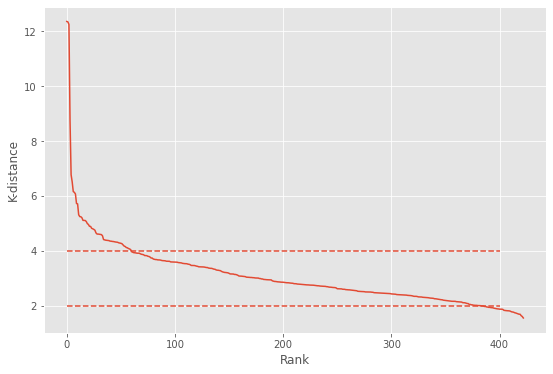

In [42]:
minPts=20;
k=minPts-1;

D=squareform(pdist(x_R_scaled));

k_distances=np.zeros(D.shape[0]);

for i in range(D.shape[0]):
    distances=np.sort(D[i]);
    k_distances[i]=distances[k];
k_distances=np.sort(k_distances);
k_distances=k_distances[::-1];
    
plt.plot(k_distances);
plt.xlabel('Rank');
plt.ylabel('K-distance');
plt.hlines([2,4],0,400,linestyles='dashed');

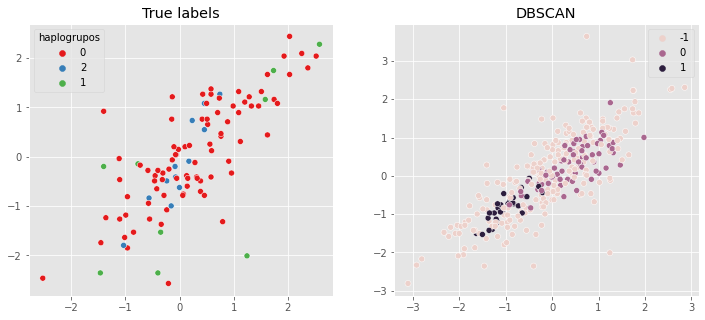

In [43]:
dbscan = DBSCAN(eps=2, min_samples=minPts)
labels_db = dbscan.fit_predict(x_R_scaled[indices])

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_R_scaled[:,0], y = x_R_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x_R_scaled[indices,0], y = x_R_scaled[indices,1],hue=labels_db,ax=ax[1])
ax[1].set_title('DBSCAN');


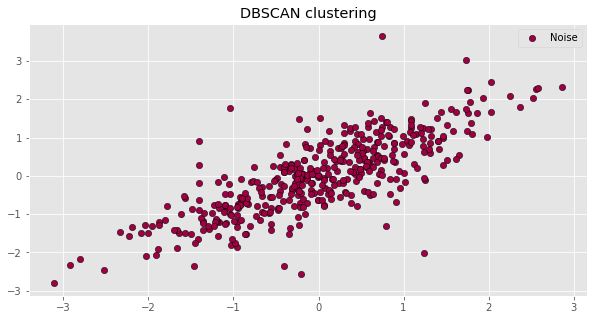

In [44]:
# Implementación de DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
y_dbscan = dbscan.fit_predict(x_R_scaled)
y_dbscan


labels = dbscan.labels_
unique_labels=set(labels);

fig, ax = plt.subplots(figsize=(10,5))

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i,l in enumerate(unique_labels):
    if l ==-1:
        ax.scatter(x_R_scaled[labels==l,0], x_R_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Noise')
    else:
        ax.scatter(x_R_scaled[labels==l,0], x_R_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Cluster '+str(l))
    
ax.legend()
ax.set_title('DBSCAN clustering');
    

# Modelos reducción dimensionalidad

## Prueba PCA

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [46]:
std_sclr = StandardScaler()

X = data[['AE','LE','AT','LT','AA','LA','NV','Morfotipo_1','Morfotipo_2','Labio','Ratio_LE_AE','Ratio_LT_AT','Ratio_LA_AA','Ratio_LE_LT','Ratio_AE_AT',\
          'Ratio_LA_LT','Ratio_AA_AT','Ratio_LE_LA','Ratio_AE_AA']]

data_std = pd.DataFrame(std_sclr.fit_transform(X))

In [47]:
model = PCA()

In [48]:
model_pca = model.fit(data_std)

### Pesos (loadings)

In [49]:
#Creamos un DataFrame con los loadings.
pca_loadings = pd.DataFrame(model_pca.components_.T, index=X.columns).iloc[:,:]
pca_loadings.rename(columns = {0 : 'CP1', 1 : 'CP2', 2 : 'CP3', 3 : 'CP4',4 : 'CP5', 5 : 'CP6', 6 : 'CP7',\
                               7 : 'CP8',8 : 'CP9', 9 : 'CP10', 10 : 'CP11', 11 : 'CP12', 12 : 'CP13', 13 : 'CP14', 14 : 'CP15', 15 : 'CP16', 16 : 'CP17', 17 : 'CP18', 18:'CP19', 19:'CP20'}, inplace = True)
pca_loadings

,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,CP11,CP12,CP13,CP14,CP15,CP16,CP17,CP18,CP19
AE,-0.341884,-0.136329,-0.172828,0.081908,-0.103045,-0.029366,0.011164,-0.084084,-0.133883,0.148621,0.223562,-0.186765,-0.061112,-0.183296,-0.298428,0.642642,-0.141701,-0.077195,0.344941
LE,-0.358494,0.087923,-0.037997,-0.124690,0.180553,0.020864,-0.059891,-0.044050,-0.061031,0.087010,0.561875,-0.428687,-0.098690,0.227788,0.241819,-0.343975,-0.095084,-0.216780,-0.054492
AT,-0.304232,-0.269800,-0.087103,0.044835,0.075600,-0.050110,-0.000881,-0.175113,0.052655,0.105255,-0.111371,0.091219,0.160440,-0.039335,-0.033785,0.187020,0.156796,-0.290806,-0.760939
LT,-0.333647,-0.190021,-0.102407,-0.125621,-0.051586,0.001593,0.026980,-0.112227,0.188646,0.131048,0.034849,-0.041958,0.011984,0.139143,-0.111023,-0.108368,0.224340,0.811650,-0.043623
AA,-0.302105,-0.283891,0.067616,-0.045231,-0.020386,-0.015819,-0.002494,-0.103511,-0.078239,0.104090,-0.225781,0.078899,0.512642,-0.171854,-0.167917,-0.465832,-0.008338,-0.229929,0.381455
LA,-0.212873,-0.330951,-0.230020,-0.234820,0.054423,0.091892,-0.116856,0.006073,-0.049873,0.081758,-0.280653,0.352421,-0.512330,0.076532,0.405919,-0.007372,-0.173410,-0.087630,0.170166
NV,-0.322517,-0.047034,-0.072928,0.067982,-0.107768,0.094482,-0.029545,0.087029,0.051500,-0.922885,0.005962,-0.004602,0.012211,-0.014084,-0.006619,0.004538,0.001740,0.001708,-0.000046
Morfotipo_1,0.043833,-0.047625,-0.168922,-0.254214,0.219560,-0.241986,0.860840,0.038668,-0.205855,-0.104226,-0.007908,-0.000555,-0.001567,0.004265,0.001944,-0.000785,0.002740,0.001227,0.003268
Morfotipo_2,0.009717,-0.011667,0.046206,0.194975,0.086885,0.909000,0.311295,-0.156237,-0.010718,0.065529,0.004837,0.001886,-0.001321,0.002771,-0.004884,0.000496,0.002162,-0.000833,-0.000663
Labio,-0.174579,-0.180209,0.103878,0.330754,0.182715,0.004965,0.105829,0.836045,0.222018,0.153360,-0.001623,-0.018049,-0.006346,-0.003907,0.008117,-0.000282,0.003184,-0.002179,0.001172


In [50]:
def plot_explained_variance(components_count, X):

    model_pca = PCA(components_count).fit(X)

    explained_variance = model_pca.explained_variance_ratio_

    #print(explained_variance)

    cumulative_explained_variance = np.cumsum(explained_variance)

    #print(cumulative_explained_variance)

    plt.plot(cumulative_explained_variance)
    plt.xlabel('número de componentes')
    plt.ylabel('% de varianza explicada');

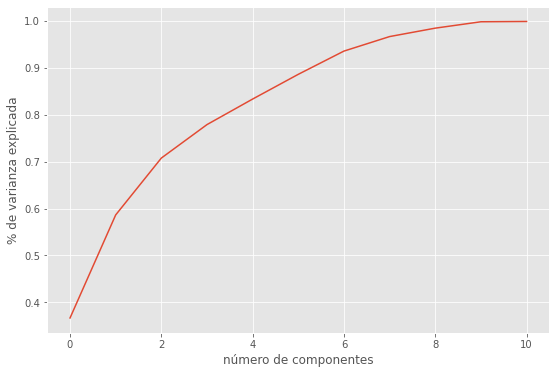

In [51]:
plot_explained_variance(components_count = 11, X = data_std)

### Proyección

In [52]:
#nuevo dataset con cada participación de feature
nuevo_data_pca = pd.DataFrame(model_pca.fit_transform(data_std), index =X.index,\
                              columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8','PC9', 'PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','CP19'])

In [ ]:
nuevo_data_pca.head(10)

In [53]:
nuevo_data_pca.reset_index()

,index,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,CP19
0,0,-1.654952,0.041232,0.852522,-1.495220,2.407609,0.501458,-1.101919,0.743017,0.334190,-0.273081,-0.042585,-0.071770,-0.054358,0.045264,0.018554,-0.001530,-0.004899,-0.017238,0.010733
1,1,2.266369,0.275017,-1.568758,1.200139,0.095961,0.143741,-0.619563,1.400465,-0.308032,0.074431,-0.046082,-0.080315,0.037492,0.026670,-0.000339,-0.037749,0.008828,0.010013,-0.015736
2,2,-0.580689,-0.463650,1.700425,0.379678,0.411416,-0.268079,-0.028151,0.165189,0.590795,0.186086,-0.022117,-0.020994,-0.020796,-0.018515,0.010277,-0.005463,-0.002790,0.002817,0.000517
3,3,-2.687667,6.043109,-0.409365,0.641890,-1.220514,-0.080929,0.178352,-0.305421,-0.834300,-0.423143,0.037363,0.388258,0.047381,0.082179,0.017515,-0.036832,0.017679,-0.000227,-0.013503
4,4,1.517910,-0.539293,-2.128903,0.480474,0.448382,0.415913,-0.940084,1.375656,-0.098551,-0.171431,0.003158,-0.019950,0.030827,-0.013475,-0.000211,-0.003453,-0.018658,0.014398,-0.017333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,418,-0.016171,0.814758,0.956406,-0.031115,-0.511478,-0.083901,-0.252394,-0.947652,-0.225576,-0.976542,-0.039354,-0.001493,-0.020396,-0.014267,-0.011060,0.000182,-0.013548,0.008990,-0.002072
419,419,-0.962549,1.114616,0.715584,0.152147,-1.144192,0.090795,0.264571,0.984657,0.838270,-0.421341,-0.016799,-0.016839,-0.042808,-0.006770,-0.018504,-0.009672,0.023533,-0.007520,0.001719
420,420,-1.784041,2.172001,2.260421,0.848483,-0.213519,-0.429983,0.485168,0.361144,0.428217,0.110327,0.056261,0.148869,0.010918,0.016033,0.003041,0.013428,-0.053461,0.020176,0.003430
421,421,0.887922,-2.367528,2.112162,0.124820,0.043985,-0.066132,-0.176663,0.391576,0.689255,-0.951893,-0.020131,-0.003038,0.002506,-0.046604,0.052346,-0.011662,0.020724,0.007249,0.012331


In [54]:
data.reset_index()

,index,Lote,Individuo,AE,LE,AT,LT,AA,LA,NV,...,Morfotipo_2,Ratio_LE_AE,Ratio_LT_AT,Ratio_LA_AA,Ratio_LE_LT,Ratio_AE_AT,Ratio_LA_LT,Ratio_AA_AT,Ratio_LE_LA,Ratio_AE_AA
0,0,96,1,6.11,2.22,13.95,10.39,8.19,6.99,5.30,...,0,0.363339,0.744803,0.853480,0.213667,0.437993,0.672762,0.587097,0.317597,0.746032
1,1,96,2,5.69,1.45,11.68,8.34,6.45,5.89,5.00,...,0,0.254833,0.714041,0.913178,0.173861,0.487158,0.706235,0.552226,0.246180,0.882171
2,2,96,5,6.14,1.80,13.72,10.00,8.13,6.08,5.12,...,0,0.293160,0.728863,0.747847,0.180000,0.447522,0.608000,0.592566,0.296053,0.755228
3,3,96,6,6.54,2.18,11.66,9.21,6.66,4.93,5.47,...,0,0.333333,0.789880,0.740240,0.236699,0.560892,0.535288,0.571184,0.442191,0.981982
4,4,99,1,6.01,1.58,12.59,9.09,6.92,6.61,5.15,...,0,0.262895,0.722002,0.955202,0.173817,0.477363,0.727173,0.549643,0.239032,0.868497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,418,554,5,5.99,1.73,12.72,9.37,7.53,5.77,5.37,...,0,0.288815,0.736635,0.766268,0.184632,0.470912,0.615795,0.591981,0.299827,0.795485
419,419,554,6,6.17,1.78,12.63,9.89,7.47,5.80,5.40,...,0,0.288493,0.783056,0.776439,0.179980,0.488519,0.586451,0.591449,0.306897,0.825971
420,420,554,7,6.20,1.95,12.82,9.67,7.67,5.23,5.23,...,0,0.314516,0.754290,0.681877,0.201655,0.483619,0.540848,0.598284,0.372849,0.808344
421,421,554,8,5.63,1.48,13.38,9.60,8.14,6.27,5.33,...,0,0.262877,0.717489,0.770270,0.154167,0.420777,0.653125,0.608371,0.236045,0.691646


In [56]:
nuevo2= pd.concat([nuevo_data_pca, data["haplogrupos"]], axis=1)

In [57]:
nuevo2.head(5)
#nuevo2.replace("NaN",0)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,CP19,haplogrupos
0,-1.654952,0.041232,0.852522,-1.495220,2.407609,0.501458,-1.101919,0.743017,0.334190,-0.273081,-0.042585,-0.071770,-0.054358,0.045264,0.018554,-0.001530,-0.004899,-0.017238,0.010733,0
1,2.266369,0.275017,-1.568758,1.200139,0.095961,0.143741,-0.619563,1.400465,-0.308032,0.074431,-0.046082,-0.080315,0.037492,0.026670,-0.000339,-0.037749,0.008828,0.010013,-0.015736,2
2,-0.580689,-0.463650,1.700425,0.379678,0.411416,-0.268079,-0.028151,0.165189,0.590795,0.186086,-0.022117,-0.020994,-0.020796,-0.018515,0.010277,-0.005463,-0.002790,0.002817,0.000517,NaN
3,-2.687667,6.043109,-0.409365,0.641890,-1.220514,-0.080929,0.178352,-0.305421,-0.834300,-0.423143,0.037363,0.388258,0.047381,0.082179,0.017515,-0.036832,0.017679,-0.000227,-0.013503,NaN
4,1.517910,-0.539293,-2.128903,0.480474,0.448382,0.415913,-0.940084,1.375656,-0.098551,-0.171431,0.003158,-0.019950,0.030827,-0.013475,-0.000211,-0.003453,-0.018658,0.014398,-0.017333,2


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

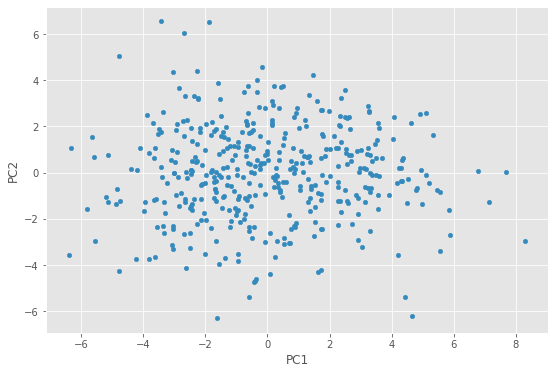

In [58]:
nuevo2.plot(x="PC1", y="PC2", kind ="scatter")

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

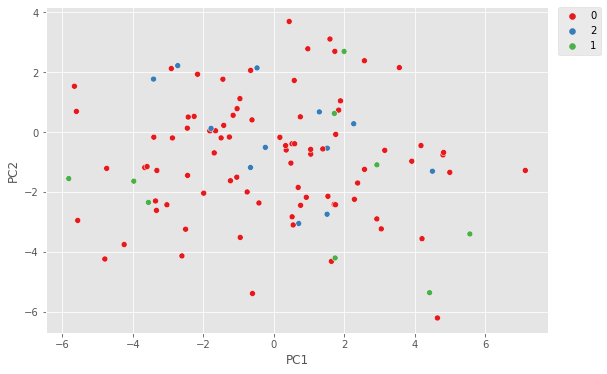

In [59]:
sns.scatterplot(data=nuevo2,x="PC1", y="PC2",hue="haplogrupos", palette="Set1")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [60]:
#indices2 = nuevo2[nuevo2["haplogrupos"]!="0"].index

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

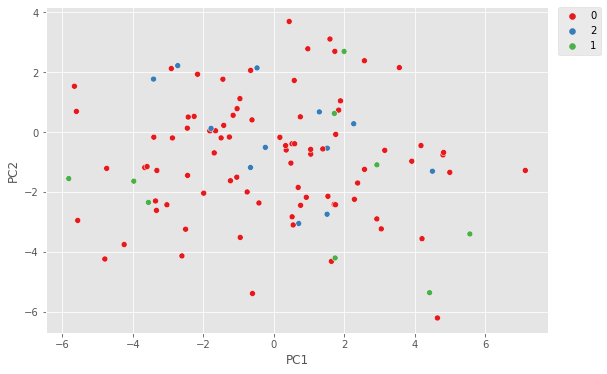

In [61]:
sns.scatterplot(data=nuevo2,x=nuevo2.PC1, y=nuevo2.PC2,hue="haplogrupos", palette="Set1")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [62]:
model_pca.explained_variance_ratio_

array([3.66760728e-01, 2.19674527e-01, 1.21226496e-01, 7.13598782e-02,
       5.44634344e-02, 5.27311542e-02, 4.95109286e-02, 3.09393326e-02,
       1.79486570e-02, 1.36116002e-02, 6.42903230e-04, 3.91488030e-04,
       2.20745840e-04, 1.72664653e-04, 1.33633328e-04, 9.89498720e-05,
       5.85564116e-05, 3.06936492e-05, 2.36293978e-05])

### Bastón quebrado

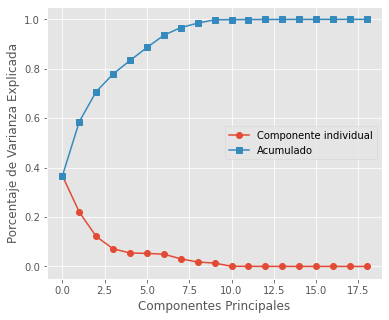

In [63]:
plt.figure(figsize=(6,5))

plt.plot(model_pca.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(np.cumsum(model_pca.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada'); plt.xlabel('Componentes Principales')
plt.ylim(-0.05,1.05); plt.xticks()
plt.legend(loc=0);

## Prueba TSNE

In [64]:
from sklearn.manifold import TSNE

In [65]:
tsne = TSNE(random_state=42)

proj_tsne = tsne.fit_transform(data_std)

In [66]:
data_std.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.134438,1.216377,0.350529,0.425324,0.401795,0.794755,0.520965,-0.390626,-0.084515,0.856508,2.185259,0.196783,0.432919,1.385888,-1.126898,0.556346,0.267887,0.632387,-0.991902
1,-0.563472,-0.835657,-0.820108,-1.004653,-1.010947,-0.411139,-0.488972,-0.390626,-0.084515,0.856508,-0.728884,-0.668713,1.201004,-0.238057,0.591529,1.184606,-0.948678,-0.675756,0.996406
2,-0.103793,0.097086,0.231918,0.153279,0.353080,-0.202848,-0.084997,-0.390626,-0.084515,0.856508,0.300454,-0.251693,-0.926155,0.012396,-0.793835,-0.659197,0.458683,0.237765,-0.857597
3,0.304810,1.109778,-0.830422,-0.397785,-0.840444,-1.463555,1.093262,-0.390626,-0.084515,-1.167531,1.379402,1.465046,-1.024030,2.325522,3.168727,-2.023956,-0.287291,2.914587,2.454152
4,-0.236589,-0.489210,-0.350822,-0.481490,-0.629344,0.378173,0.015997,-0.390626,-0.084515,0.856508,-0.512359,-0.444741,1.741688,-0.239833,0.249185,1.577592,-1.038809,-0.806690,0.796705


In [67]:
nuevo3= pd.DataFrame(proj_tsne)

In [68]:
nuevo3.head()

,0,1
0,-20.783741,7.656449
1,-2.762976,-10.293843
2,-6.749123,1.150071
3,6.654214,9.134555
4,-3.616528,-9.976585


In [69]:
nuevo4= pd.concat([nuevo3, data["haplogrupos"]], axis=1)

In [70]:
nuevo4.columns = ["X","Y","haplogrupos"]

In [71]:
nuevo4.head()

,X,Y,haplogrupos
0,-20.783741,7.656449,0
1,-2.762976,-10.293843,2
2,-6.749123,1.150071,NaN
3,6.654214,9.134555,NaN
4,-3.616528,-9.976585,2


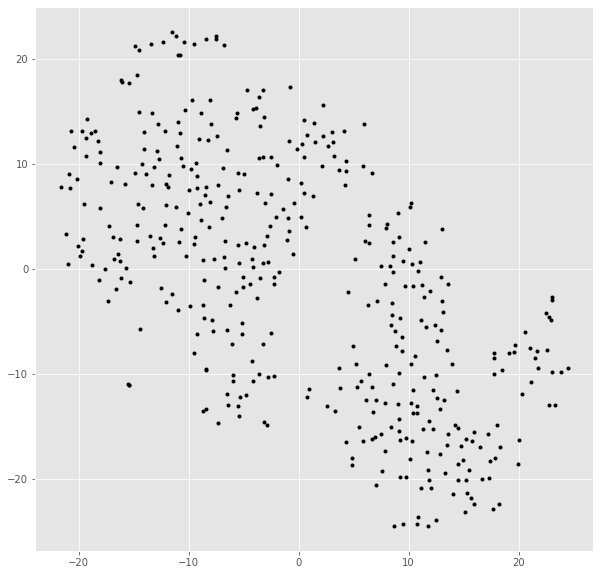

In [72]:
fig, ax = plt.subplots(figsize=(10, 10))

# get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
ax = ax or plt.gca()
    
coord_x = proj_tsne[:, 0]
coord_y = proj_tsne[:, 1]
ax.plot(coord_x, coord_y, '.k')    

<AxesSubplot:xlabel='X', ylabel='Y'>

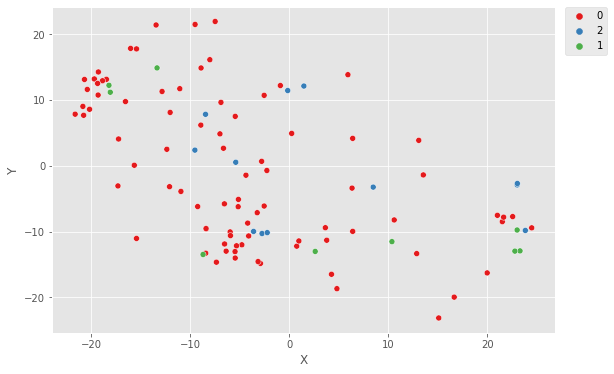

In [73]:
sns.scatterplot(data=nuevo4,x="X", y="Y",hue="haplogrupos",palette="Set1" )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Modelos clasificación

In [74]:
from sklearn.tree import DecisionTreeClassifier # to build a classification tree
from sklearn.tree import plot_tree # to draw a classification tree
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix
from sklearn.metrics import accuracy_score

## CART con oversampling target HAPLOGRUPOS

In [75]:
from sklearn.model_selection import train_test_split

In [85]:
dataNa = data.dropna()

In [86]:
dataNa.shape

(106, 23)

In [87]:
newX = dataNa[['AE','LE','AT','LT','AA','LA','NV','Morfotipo_1','Morfotipo_2','Labio','Ratio_LE_AE','Ratio_LT_AT','Ratio_LA_AA','Ratio_LE_LT','Ratio_AE_AT','Ratio_LA_LT','Ratio_AA_AT','Ratio_LE_LA','Ratio_AE_AA']]
newy = dataNa['haplogrupos']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(newX,newy,stratify = dataNa['haplogrupos'],random_state=0)

In [89]:
# chequeamos la presencia relativa de cada clase y el tamaño de los datasets
print('Entrenamiento:',X_train.shape)
print('Testeo:',X_test.shape)
print('\nClases train:')
print(y_train.value_counts(normalize=True))
print('\nClases test:')
print(y_test.value_counts(normalize=True))

Entrenamiento: (79, 19)
Testeo: (27, 19)

Clases train:
0    0.797468
2    0.113924
1    0.088608
Name: haplogrupos, dtype: float64

Clases test:
0    0.814815
2    0.111111
1    0.074074
Name: haplogrupos, dtype: float64


### OverSampling

In [90]:
from imblearn.over_sampling import RandomOverSampler

oversampler=RandomOverSampler(sampling_strategy='minority');

X_train_os,y_train_os=oversampler.fit_resample(X_train,y_train);

print('Composición del training set:')
print(y_train_os.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
1    63
0    63
2     9
Name: haplogrupos, dtype: int64

Composición del test set:
0    22
2     3
1     2
Name: haplogrupos, dtype: int64


In [91]:
X_train_os2,y_train_os2=oversampler.fit_resample(X_train_os,y_train_os);

print('Composición del training set:')
print(y_train_os2.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
1    63
0    63
2    63
Name: haplogrupos, dtype: int64

Composición del test set:
0    22
2     3
1     2
Name: haplogrupos, dtype: int64


## CART

### CART con variables originales oversampleadas

In [92]:
clf_dt = DecisionTreeClassifier(max_depth = 7, random_state=42)
clf_dt = clf_dt.fit(X_train_os2,y_train_os2)

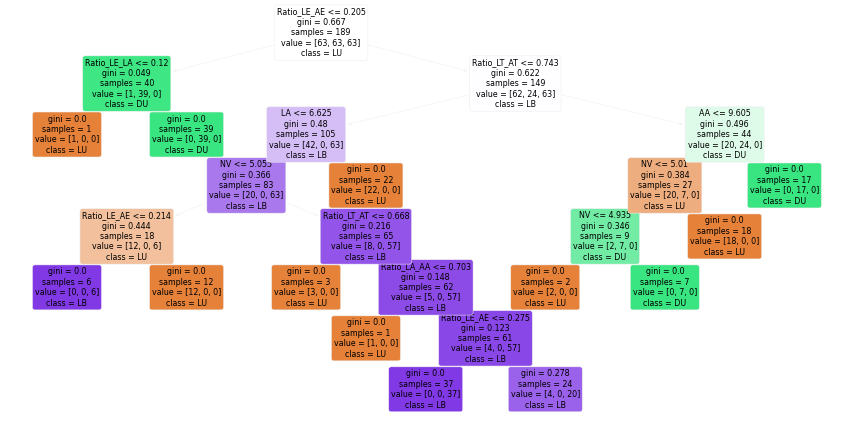

In [93]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["LU","DU", "LB"], 
          feature_names=X_train_os2.columns); 

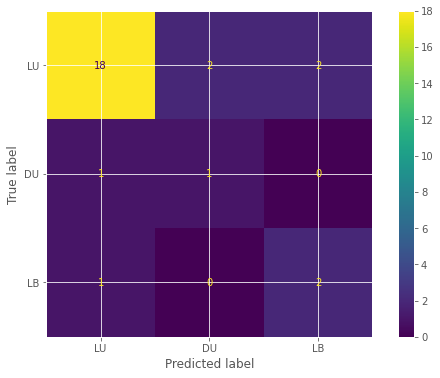

In [94]:
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=["LU","DU","LB"])

In [95]:
accuracy_score(y_test, clf_dt.predict(X_test))

0.7777777777777778

### CART con variables de PCA target HAPLOGRUPOS

In [96]:
nuevo2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          423 non-null    float64
 1   PC2          423 non-null    float64
 2   PC3          423 non-null    float64
 3   PC4          423 non-null    float64
 4   PC5          423 non-null    float64
 5   PC6          423 non-null    float64
 6   PC7          423 non-null    float64
 7   PC8          423 non-null    float64
 8   PC9          423 non-null    float64
 9   PC10         423 non-null    float64
 10  PC11         423 non-null    float64
 11  PC12         423 non-null    float64
 12  PC13         423 non-null    float64
 13  PC14         423 non-null    float64
 14  PC15         423 non-null    float64
 15  PC16         423 non-null    float64
 16  PC17         423 non-null    float64
 17  PC18         423 non-null    float64
 18  CP19         423 non-null    float64
 19  haplogru

In [97]:
nuevoPCA = nuevo2.dropna()

In [98]:
nuevoPCA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 419
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          106 non-null    float64
 1   PC2          106 non-null    float64
 2   PC3          106 non-null    float64
 3   PC4          106 non-null    float64
 4   PC5          106 non-null    float64
 5   PC6          106 non-null    float64
 6   PC7          106 non-null    float64
 7   PC8          106 non-null    float64
 8   PC9          106 non-null    float64
 9   PC10         106 non-null    float64
 10  PC11         106 non-null    float64
 11  PC12         106 non-null    float64
 12  PC13         106 non-null    float64
 13  PC14         106 non-null    float64
 14  PC15         106 non-null    float64
 15  PC16         106 non-null    float64
 16  PC17         106 non-null    float64
 17  PC18         106 non-null    float64
 18  CP19         106 non-null    float64
 19  haplogru

In [99]:
X_PCA = nuevoPCA[['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6']]
y_PCA = nuevoPCA['haplogrupos']

In [100]:
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA,y_PCA,stratify = nuevoPCA['haplogrupos'],random_state=0)

In [101]:
clf_dt = DecisionTreeClassifier(max_depth = 4, random_state=42)
clf_dt = clf_dt.fit(X_train_PCA,y_train_PCA)

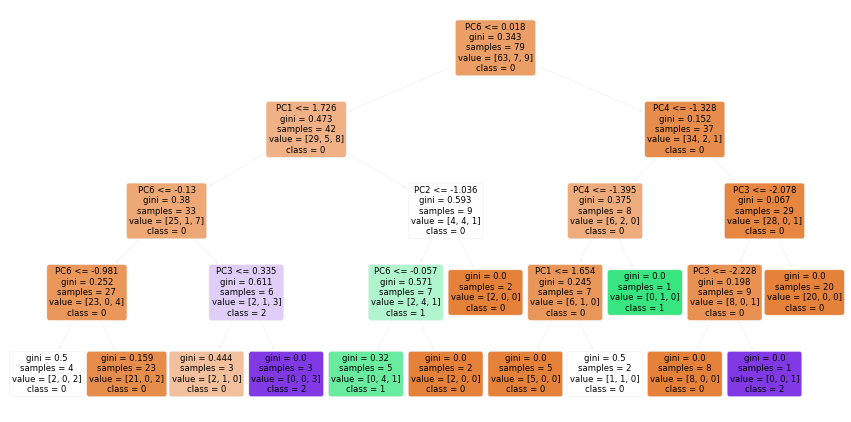

In [102]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["0","1", "2"], 
          feature_names=X_train_PCA.columns); 

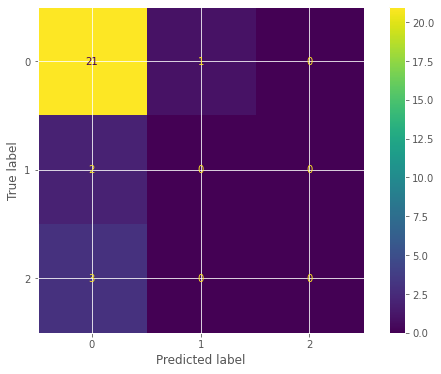

In [103]:
plot_confusion_matrix(clf_dt, X_test_PCA, y_test_PCA, display_labels=["0","1","2"])

In [104]:
accuracy_score(y_test_PCA, clf_dt.predict(X_test_PCA))

0.7777777777777778

## XGBoost

In [105]:
from xgboost import XGBClassifier


In [106]:
y_train_PCA = y_train_PCA.astype("int")

In [107]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train_PCA)
y_train_PCA = le.transform(y_train_PCA)

LabelEncoder()

In [108]:
xgboost = XGBClassifier()

In [109]:
clf_XGB = xgboost.fit(X_train_PCA,y_train_PCA)

In [110]:
accuracy_score(le.transform(y_test_PCA), xgboost.predict(X_test_PCA))

ValueError: y contains previously unseen labels: '2'